In [ ]:
!mkdir out
%pip install wandb 

In [ ]:
%pip install -U rliable

In [ ]:
!wandb login

In [1]:
import wandb

In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import pickle

import os 

os.makedirs("out", exist_ok=True)
os.makedirs("bin", exist_ok=True)

In [2]:
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['figure.dpi']= 300
sns.set(style="ticks", font_scale=1.5)
plt.rcParams.update({
    # 'font.family': 'serif',
    'font.serif': 'Times New Roman'
})
#sns.set_palette("tab19")

# EOP

In [4]:
"""
Taken from here and a bit modified
https://github.com/dodgejesse/show_your_work/
"""

import numpy as np
from typing import List, Dict, Union


def _cdf_with_replacement(i,n,N):
    return (i/N)**n


def _compute_stds(N, cur_data, expected_max_cond_n, pdfs):
    """
    this computes the standard error of the max.
    this is what the std dev of the bootstrap estimates of the mean of the max converges to, as
    is stated in the last sentence of the summary on page 10 of 
    http://www.stat.cmu.edu/~larry/=stat705/Lecture13.pdf
    """
    std_of_max_cond_n = []
    for n in range(N):
        # for a given n, estimate variance with \sum(p(x) * (x-mu)^2), where mu is \sum(p(x) * x).
        cur_std = 0
        for i in range(N):
            cur_std += (cur_data[i] - expected_max_cond_n[n])**2 * pdfs[n][i]
        cur_std = np.sqrt(cur_std)
        std_of_max_cond_n.append(cur_std)
    return std_of_max_cond_n
    

# this implementation assumes sampling with replacement for computing the empirical cdf
def expected_online_performance(
    online_performance: List[float],
    output_n          : int
) -> Dict[str, Union[List[float], float]]:
    # Copy and sort?
    online_performance = list(online_performance)
    online_performance.sort()

    N    = len(online_performance)
    pdfs = []
    for n in range(1,N+1):
        # the CDF of the max
        F_Y_of_y = []
        for i in range(1,N+1):
            F_Y_of_y.append(_cdf_with_replacement(i,n,N))


        f_Y_of_y = []
        cur_cdf_val = 0
        for i in range(len(F_Y_of_y)):
            f_Y_of_y.append(F_Y_of_y[i] - cur_cdf_val)
            cur_cdf_val = F_Y_of_y[i]
        
        pdfs.append(f_Y_of_y)

    expected_max_cond_n = []
    expected_med_cond_n = []
    expected_iqr_cond_n = []
    for n in range(N):
        # for a given n, estimate expected value with \sum(x * p(x)), where p(x) is prob x is max.
        cur_expected = 0
        for i in range(N):
            cur_expected += online_performance[i] * pdfs[n][i]
        expected_max_cond_n.append(cur_expected)

        # estimate median
        cur_sum = 0.0
        for i in range(N):
            cur_sum += pdfs[n][i]
            if cur_sum == 0.5:
                expected_med_cond_n.append(online_performance[i])
                break
            elif cur_sum > 0.5:
                # nearest strat
                cur_diff = cur_sum - 0.5
                prev_dif = 0.5 - (cur_sum - pdfs[n][-1])
                if cur_diff < prev_dif:
                    expected_med_cond_n.append(online_performance[i])
                else:
                    expected_med_cond_n.append(online_performance[i-1])
                break

        # estimate iqr
        cur_sum = 0.0
        percent25 = 0.0
        checked25 = False

        percent75 = 0.0
        checked75 = False
        for i in range(N):
            cur_sum += pdfs[n][i]
            if not checked25:
                if cur_sum == 0.25:
                    percent25 = online_performance[i]
                    checked25 = True
                elif cur_sum > 0.25:
                    # nearest strat
                    cur_diff = cur_sum - 0.25
                    prev_dif = 0.25 - (cur_sum - pdfs[n][-1])
                    if cur_diff < prev_dif:
                        percent25 = online_performance[i]
                    else:
                        percent25 = online_performance[i-1]

            if not checked75:
                if cur_sum == 0.75:
                    percent75 = online_performance[i]
                    checked75 = True
                elif cur_sum > 0.75:
                    # nearest strat
                    cur_diff = cur_sum - 0.75
                    prev_dif = 0.75 - (cur_sum - pdfs[n][-1])
                    if cur_diff < prev_dif:
                        percent75 = online_performance[i]
                    else:
                        percent75 = online_performance[i-1]
        expected_iqr_cond_n.append(percent75 - percent25)


    std_of_max_cond_n = _compute_stds(N, online_performance, expected_max_cond_n, pdfs)

    return {
        "median": expected_med_cond_n[:output_n],
        "iqr": expected_iqr_cond_n[:output_n],
        "mean": expected_max_cond_n[:output_n],
        "std" : std_of_max_cond_n[:output_n],
        "max" : np.max(online_performance),
        "min" : np.min(online_performance)
    }

def expected_online_performance_arbit(
    online_performance : List[float],
    offline_performance: List[float],
    output_n           : int
) -> Dict[str, Union[List[float], float]]:
    means = [x for _, x in sorted(zip(offline_performance, online_performance), key=lambda pair: pair[0], reverse=True)]

    if len(means) > 0:
        cur_max = means[0]
        for ind in range(len(means)):
            cur_max = max(cur_max, means[ind])
            means[ind] = cur_max

    return {
        "mean": means[:output_n],
        "std" : means[:output_n],
        "max" : np.max(online_performance),
        "min" : np.min(online_performance)
    }

In [5]:
def plot_paper(rewards, labels, title, save_name=None, bp=None):
    plt.rcParams['axes.facecolor'] = 'none'
    max_runs = max(map(len, rewards))
    x = np.arange(max_runs) + 1
    if bp:
        labels = ['Behavioral Policy'] + labels
        plt.plot(x, [bp] * max_runs, linestyle='dashed')
    #colors = ['tab:green', 'gold', 'tab:green']#sns.color_palette()
    markers = ['o']#, 's', '^', 'p', 'D', 'P']
    for i, reward in enumerate(rewards):
        perf = expected_online_performance(reward, len(reward))
        means = np.array(perf['mean'])
        plt.plot(x[:len(means)], means, marker=markers[i % len(markers)], label=labels[i])#, color=colors[i])
        plt.fill_between(x[:len(means)], means - perf['std'], means + perf['std'], alpha=0.1)#, color=colors[i])
        print(f'Last point {labels[i]}:', means[-1], '+-', perf['std'][-1])
        #plt.fill_between(x, means - perf['std'], means + perf['std'], alpha=0.1, color=plt.gca().lines[-1].get_color())

    plt.xlabel('Policies evaluated online')
    plt.ylabel('Expected Online Performance')
    plt.title(title)
    plt.grid(False)
    plt.tick_params(color='black', labelcolor='black')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
   
    plt.xticks(list(np.arange(1, max_runs + 1, 1))) #+ [12])
    if save_name:
        plt.savefig(save_name, bbox_inches='tight', dpi=300)
    plt.show()

In [6]:
def get_data_from_sweeps(sweeps_ids, param_1="actor_bc_coef", param_2="critic_bc_coef"):
    maxes = []
    lasts = []
    name_list = [] 
    config_list = []
    full_scores = {}


    for s in tqdm(sweeps_ids, desc="Sweeps processing", position=0, leave=True):
        api = wandb.Api(timeout=39)
        sweep = api.sweep(s)
        runs = sweep.runs
        for run in tqdm(runs, desc="Runs processing", position=0, leave=True):
            all_scores = []

            config = {k:v for k,v in run.config.items() if not k.startswith('_')}
            # print(run.name, end=' ')
            for i, row in run.history(keys=["eval/normalized_score_mean"], samples=3000).iterrows():
                last = row["eval/normalized_score_mean"]
                all_scores.append(last)
            if config["dataset_name"] not in full_scores:
                full_scores[config["dataset_name"]] = {}
            if str(config[param_1]) not in full_scores[config["dataset_name"]]:
                full_scores[config["dataset_name"]][str(config[param_1])] = {}
            if str(config[param_2]) not in full_scores[config["dataset_name"]][str(config[param_1])]:
                full_scores[config["dataset_name"]][str(config[param_1])][str(config[param_2])] = []
            # print("LEN", len(all_scores))
            if len(all_scores) == 0:
                continue
            last_score_idx = -1
            if "antmaze" in config["dataset_name"]:
                last_score_idx = min(20, len(all_scores) - 1)
            full_scores[config["dataset_name"]][str(config[param_1])][str(config[param_2])].append(all_scores[last_score_idx])
            config_list.append(config) 
            name_list.append(run.name)      
            lasts.append(last)

    return full_scores


def get_data_from_sweeps_iql(sweeps_ids):
    maxes = []
    lasts = []
    name_list = [] 
    config_list = []
    full_scores = {}


    for s in tqdm(sweeps_ids, desc="Sweeps processing", position=0, leave=True):
        api = wandb.Api(timeout=19)
        sweep = api.sweep(s)
        runs = sweep.runs
        for run in tqdm(runs, desc="Runs processing", position=0, leave=True):
            all_scores = []

            config = {k:v for k,v in run.config.items() if not k.startswith('_')}
            # print(run.name, end=' ')
            for i, row in run.history(keys=["d4rl_normalized_score"], samples=3000).iterrows():
                last = row["d4rl_normalized_score"]
                all_scores.append(last)
            if len(all_scores) == 0:
                continue
            if config["env"] not in full_scores:
                full_scores[config["env"]] = {}
            if str(config["beta"]) not in full_scores[config["env"]]:
                full_scores[config["env"]][str(config["beta"])] = {}
            if str(config["iql_tau"]) not in full_scores[config["env"]][str(config["beta"])]:
                full_scores[config["env"]][str(config["beta"])][str(config["iql_tau"])] = []
            # print("LEN", len(all_scores))
            full_scores[config["env"]][str(config["beta"])][str(config["iql_tau"])].append(all_scores[-1])
            config_list.append(config) 
            name_list.append(run.name)      
            lasts.append(last)

    return full_scores

In [7]:
def fill_td3(full_means):
    full_means["relocate-expert-v1"]["0"]["0.4"] = 107.9
    full_means["relocate-human-v1"]["0"]["0.4"] = 0.0
    full_means["relocate-cloned-v1"]["0"]["0.4"] = -0.1
    full_means["pen-expert-v1"]["0"]["0.4"] = 144.9
    full_means["pen-human-v1"]["0"]["0.4"] = 65.9
    full_means["pen-cloned-v1"]["0"]["0.4"] = 78.1
    full_means["hammer-expert-v1"]["0"]["0.4"] = 127.0
    full_means["hammer-human-v1"]["0"]["0.4"] = 0.3
    full_means["hammer-cloned-v1"]["0"]["0.4"] = 1.1
    full_means["door-expert-v1"]["0"]["0.4"] = 102.5
    full_means["door-human-v1"]["0"]["0.4"] = 0.0
    full_means["door-cloned-v1"]["0"]["0.4"] = 0.4
    full_means["hopper-full-replay-v2"]["0"]["0.4"] = 49.9
    full_means["hopper-expert-v2"]["0"]["0.4"] = 108.7
    full_means["hopper-random-v2"]["0"]["0.4"] = 10.3
    full_means["hopper-medium-replay-v2"]["0"]["0.4"] = 64.5
    full_means["hopper-medium-expert-v2"]["0"]["0.4"] = 75.8
    full_means["hopper-medium-v2"]["0"]["0.4"] = 53.2
    full_means["walker2d-full-replay-v2"]["0"]["0.4"] = 86.7
    full_means["walker2d-expert-v2"]["0"]["0.4"] = 109.1
    full_means["walker2d-random-v2"]["0"]["0.4"] = 4.5
    full_means["walker2d-medium-replay-v2"]["0"]["0.4"] = 50.9
    full_means["walker2d-medium-expert-v2"]["0"]["0.4"] = 108.9
    full_means["walker2d-medium-v2"]["0"]["0.4"] =  77.1
    full_means["halfcheetah-full-replay-v2"]["0"]["0.4"] = 69.3
    full_means["halfcheetah-expert-v2"]["0"]["0.4"] = 93.8
    full_means["halfcheetah-random-v2"]["0"]["0.4"] = 2.2
    full_means["halfcheetah-medium-replay-v2"]["0"]["0.4"] = 40.5
    full_means["halfcheetah-medium-expert-v2"]["0"]["0.4"] = 91.9
    full_means["halfcheetah-medium-v2"]["0"]["0.4"] = 44.6
    full_means["antmaze-large-play-v2"]["0"]["0.4"] = 0.0
    full_means["antmaze-medium-play-v2"]["0"]["0.4"] = 0.0
    full_means["antmaze-umaze-v2"]["0"]["0.4"] = 62.0
    full_means["antmaze-large-diverse-v2"]["0"]["0.4"] = 0.5
    full_means["antmaze-medium-diverse-v2"]["0"]["0.4"] = 0.5
    full_means["antmaze-umaze-diverse-v2"]["0"]["0.4"] = 48.0
    return full_means

def average_seeds(full_scores, is_td3=False):
    S = 0
    full_means = {}
    bests = {}
    for dataset in full_scores:
        ba, bc, bmean, bstd = 0, 0, 0, 0
        for ac in full_scores[dataset]:
            for cc in full_scores[dataset][ac]:
                score = np.mean(full_scores[dataset][ac][cc])
                std = np.std(full_scores[dataset][ac][cc])
                if bmean <=  score:
                    bmean = score
                    bstd = std
                    ba = ac
                    bc = cc
                if dataset not in full_means:
                    full_means[dataset] = {}
                ka  = ac
                if cc not in full_means[dataset]:
                    full_means[dataset][cc] = {}
                full_means[dataset][cc][ka] = score
        bests[dataset] = {} 
        bests[dataset]["best_coefs"] = (float(ba), float(bc))
        bests[dataset]["best_mean"] = f"{bmean} +- {bstd}"
        S += bmean
    if is_td3:
        full_means = fill_td3(full_means)
    return full_means

In [8]:
domain2envs = {
    "Locomotion": ["hopper", "walker2d", "halfcheetah"],
    "AntMaze": ["antmaze"],
    "Adroit": ["pen", "door", "hammer", "relocate"]
}

def average_domains(full_means):
    domain_avgereged =  {}

    unique_cc = {
        "Locomotion": None,
        "AntMaze": None,
        "Adroit": None
    }
    unique_ac = {
        "Locomotion": None,
        "AntMaze": None,
        "Adroit": None
    }

    unique_cc["Locomotion"] = list(full_means["hopper-medium-v2"].keys())
    unique_ac["Locomotion"] = list(full_means["hopper-medium-v2"][unique_cc["Locomotion"][0]].keys())

    unique_cc["AntMaze"] = list(full_means["antmaze-umaze-v2"].keys())
    unique_ac["AntMaze"] = list(full_means["antmaze-umaze-v2"][unique_cc["AntMaze"][0]].keys())

    unique_cc["Adroit"] = list(full_means["door-expert-v1"].keys())
    unique_ac["Adroit"] = list(full_means["door-expert-v1"][unique_cc["Adroit"][0]].keys())
        
    for domain in ["Locomotion", "AntMaze", "Adroit"]:
        domain_avgereged[domain] = {}
        for cc in unique_cc[domain]:
            if cc not in domain_avgereged[domain]:
                domain_avgereged[domain][cc] = {}
            for ac in unique_ac[domain]:
                avg = []
                for data in full_means:
                    is_domain = False
                    for env in domain2envs[domain]:
                        if env in data:
                            is_domain = True
                            break
                    if is_domain:
                        avg.append(full_means[data][cc][ac])
                domain_avgereged[domain][cc][ac] = np.mean(avg)  

    return domain_avgereged

In [9]:
def listed_avg(data):
    listed_avg = {}

    for env in data:
        if env not in listed_avg:
            listed_avg[env] = []
        for ac in data[env]:
            for cc in data[env][ac]:
                listed_avg[env].append(data[env][ac][cc])
    return listed_avg

In [10]:
def download_data(algo_to_sweeps):
    data = {}
    for algo in algo_to_sweeps:
        print(f"Downloading {algo} data")
        if "IQL" in algo:
            data[algo] = get_data_from_sweeps_iql(algo_to_sweeps[algo])
        else:    
            data[algo] = get_data_from_sweeps(algo_to_sweeps[algo])
    
    full_means = {}
    for algo in data:
        full_means[algo] = average_seeds(data[algo], "TD3" in algo)
    
    domains_avg = {}
    for algo in full_means:
        domains_avg[algo] = average_domains(full_means[algo])

    listed_all = {}
    listed_domains = {}
    for algo in full_means:
        listed_all[algo] = listed_avg(full_means[algo])
        listed_domains[algo] = listed_avg(domains_avg[algo])

    return listed_all, listed_domains

In [ ]:
### Run this code only if you have acceses to the wandb projects
# listed_all, listed_domains = download_data(
#     {
#         "ReBRAC": ["adagrad/DOUP/sweeps/rs5ps1bb", "adagrad/DOUP/sweeps/nr2a6oqo", "tlab/DOUP/sweeps/9w2m7f5h", "tlab/DOUP/sweeps/o6mm4qgr", "tlab/DOUP/sweeps/hknpnbd5", "tlab/DOUP/sweeps/hls37v80"],
#         "TD3 + BC": ["tlab/DOUP/sweeps/sv1ohbqd", "tlab/DOUP/sweeps/74y04280"],
#         "IQL": ["tlab/IQL-tune/sweeps/rffj44jt"],
#     }
# )

# with open('bin/eop_domains.pickle', 'wb') as handle:
#     pickle.dump(listed_domains, handle, protocol=pickle.HIGHEST_PROTOCOL)
# with open('bin/eop_all.pickle', 'wb') as handle:
#     pickle.dump(listed_all, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [11]:
with open('bin/eop_domains.pickle', 'rb') as handle:
    listed_domains = pickle.load(handle)
with open('bin/eop_all.pickle', 'rb') as handle:
    listed_all = pickle.load(handle)

In [12]:
def plot(listed_data):
    algorithms = list(listed_data.keys())
    fst_algo = algorithms[0]
    
    all_keys = list(sorted(listed_data[fst_algo].keys()))
    all_values = {
        algo: [listed_data[algo][n] for n in all_keys] for algo in listed_data
    }

    for i, name in enumerate(all_keys):
        plot_paper([all_values[algo][i] for algo in algorithms], algorithms, name, save_name=f'out/{name}_eop.pdf')

In [ ]:
plot(listed_all)

In [ ]:
plot(listed_domains)

In [18]:
import numpy as np
def print_tables(data):
    algorithms = ["TD3 + BC", "IQL", "ReBRAC"]
    print(algorithms)
    fst_algo = algorithms[0]

    all_keys = list(sorted(data[fst_algo].keys()))
    all_values = {
        algo: [data[algo][n] for n in all_keys] for algo in algorithms
    }
    for i, name in enumerate(all_keys):
        print("=" * 30)
        print(name)
        print()
        rewards = [data[algo][name] for algo in algorithms]
        max_runs = max(map(len, rewards))
        x = np.arange(max_runs) + 1
        for algo, reward in zip(algorithms, rewards):
            perf = expected_online_performance(reward, len(reward))
            means = np.array(perf['mean'])
            stds = np.array(perf['std'])
            print("& \\textbf{" + algo + "} &", end=" ")
            for point in [0, 1, 2, 4, 9, 14, 19]:
                if point >= len(reward):
                    print("-", end=(" & " if point != 19 else "\\\\\n"))
                else:
                    print("{:3.1f}".format(means[point]) , "$\pm$", "{:3.1f}".format(stds[point]), end=(" & " if point != 19 else "\\\\\n"))

def print_v_tables(data):
    algorithms = ["TD3 + BC", "IQL", "ReBRAC"]
    print(algorithms)
    fst_algo = algorithms[0]

    locomotion_envs = ["halfcheetah", "hopper", "walker2d"]
    adroit_envs = ["pen", "door", "hammer", "relocate"]
    
    locomotion_datasets = [
        "random-v2",
        "medium-v2",
        "expert-v2",
        "medium-expert-v2",
        "medium-replay-v2",
        "full-replay-v2",
    ]
    antmaze_datasets = [
        "umaze-v2",
        "medium-play-v2",
        "large-play-v2",
        "umaze-diverse-v2",
        "medium-diverse-v2",
        "large-diverse-v2",
    ]
    adroit_datasets = [
        "human-v1",
        "cloned-v1",
        "expert-v1",
    ]

    concated = {
        env: {} for env in locomotion_envs + ["antmaze"] + adroit_envs
    }

    for env in locomotion_envs:
        for dataset in locomotion_datasets:
            concated[env][dataset] = ["" for _ in range(20)]
    for env in ["antmaze"]:
        for dataset in antmaze_datasets:
            concated[env][dataset] = ["" for _ in range(20)]
    for env in adroit_envs:
        for dataset in adroit_datasets:
            concated[env][dataset] = ["" for _ in range(20)]


    all_keys = list(sorted(data[fst_algo].keys()))
    all_values = {
        algo: [data[algo][n] for n in all_keys] for algo in algorithms
    }
    for i, name in enumerate(all_keys):
        env_name = name.split('-')[0]
        dataset_name = '-'.join(name.split('-')[1:])

        rewards = [data[algo][name] for algo in algorithms]
        max_runs = max(map(len, rewards))
        x = np.arange(max_runs) + 1
        for point in range(20):
            alg_n = 0
            max_idx = 0
            max_val = -10
            strings = []
            for algo, reward in zip(algorithms, rewards):
                perf = expected_online_performance(reward, len(reward))
                means = np.array(perf['mean'])
                stds = np.array(perf['std'])
                if point >= len(means):
                    strings.append("-")
                else:
                    strings.append("{:3.1f}".format(means[point]) + " $\\pm$ " + "{:3.1f}".format(stds[point]))
                    if max_val <  means[point]:
                        max_val = means[point]
                        max_idx = alg_n
                alg_n += 1
            strings[max_idx] = "\\textbf{" + strings[max_idx] + "}"
            concated[env_name][dataset_name][point] = " & ".join(strings) + " & "

    for envs, datasets in zip([locomotion_envs, ["antmaze"], adroit_envs], [locomotion_datasets, antmaze_datasets, adroit_datasets]):
        for env in envs:
            print("=" * 30)
            print(env)
            for i in range(20):
                print(i + 1, "&", ("".join([concated[env][dataset][i] for dataset in datasets]))[:-2], "\\\\")        

In [ ]:
print_tables(listed_domains)

In [ ]:
print_v_tables(listed_all)

In [ ]:
# !zip -r eop.zip out

# Profiles

In [3]:
def flatten(data):
    flat = []
    for env in data:
        env_list = []
        for cc in data[env]:
            for ac in data[env][cc]:
                env_list += data[env][cc][ac]
        flat.append(env_list)
    return flat

In [27]:
### Run this code only if you have acceses to the wandb projects

# rebrac_eval_data = get_data_from_sweeps(
#     ["tlab/DOUP/sweeps/vp1a0494", "tlab/DOUP/sweeps/x04zqjbc", "adagrad/DOUP/sweeps/cq7frovf"]
# )
# rebrac_reeval_data = get_data_from_sweeps(
#     ["adagrad/DOUP/sweeps/y1spavlz"]
# )

# for k in rebrac_reeval_data:
#     rebrac_eval_data[k] = rebrac_reeval_data[k]

# td3_bc_eval_data = get_data_from_sweeps(
#     ["tlab/DOUP/sweeps/kr9goiui"]
# )

# td3_bc_reeval_data = get_data_from_sweeps(
#     ["tlab/DOUP/sweeps/mpf4y6oo"]
# )

# for k in td3_bc_reeval_data:
#     td3_bc_eval_data[k] = td3_bc_reeval_data[k]


# iql_eval_data = get_data_from_sweeps_iql(
#     ["tlab/IQL-tune/sweeps/9hfb53n8"]
# )

# sac_rnd_eval_data = get_data_from_sweeps(
#     ["tlab/SAC-RND/sweeps/1kag0s2o", "tlab/SAC-RND/sweeps/6r8mh0vc"],
#     param_1="actor_beta",
#     param_2="critic_beta",
# )
# sac_rnd_eval_data_2 = get_data_from_sweeps(
#     ["tlab/SAC-RND/sweeps/8i7ad5p1"],
#     param_1="beta",
#     param_2="beta",
# )

# for k in sac_rnd_eval_data_2:
#     sac_rnd_eval_data[k] = sac_rnd_eval_data_2[k]
    
# eval_data = {
#     "ReBRAC": rebrac_eval_data,
#     "TD3 + BC": td3_bc_eval_data,
#     "IQL": iql_eval_data,
#     "SAC-RND": sac_rnd_eval_data
# }

# with open('bin/profiles_data.pickle', 'wb') as handle:
#     pickle.dump(eval_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

Sweeps processing: 100%|██████████| 1/1 [01:02<00:00, 62.45s/it]


In [11]:
with open('bin/profiles_data.pickle', 'rb') as handle:
    eval_data = pickle.load(handle)

In [12]:
rebrac_flat = flatten(eval_data["ReBRAC"])
td3_bc_flat = flatten(eval_data["TD3 + BC"])
iql_flat = flatten(eval_data["IQL"])
sac_rnd_flat = flatten(eval_data["SAC-RND"])

In [13]:
from rliable import library as rly
from rliable import metrics
from rliable import plot_utils

In [14]:
sns.set(style="ticks", font_scale=1.0)

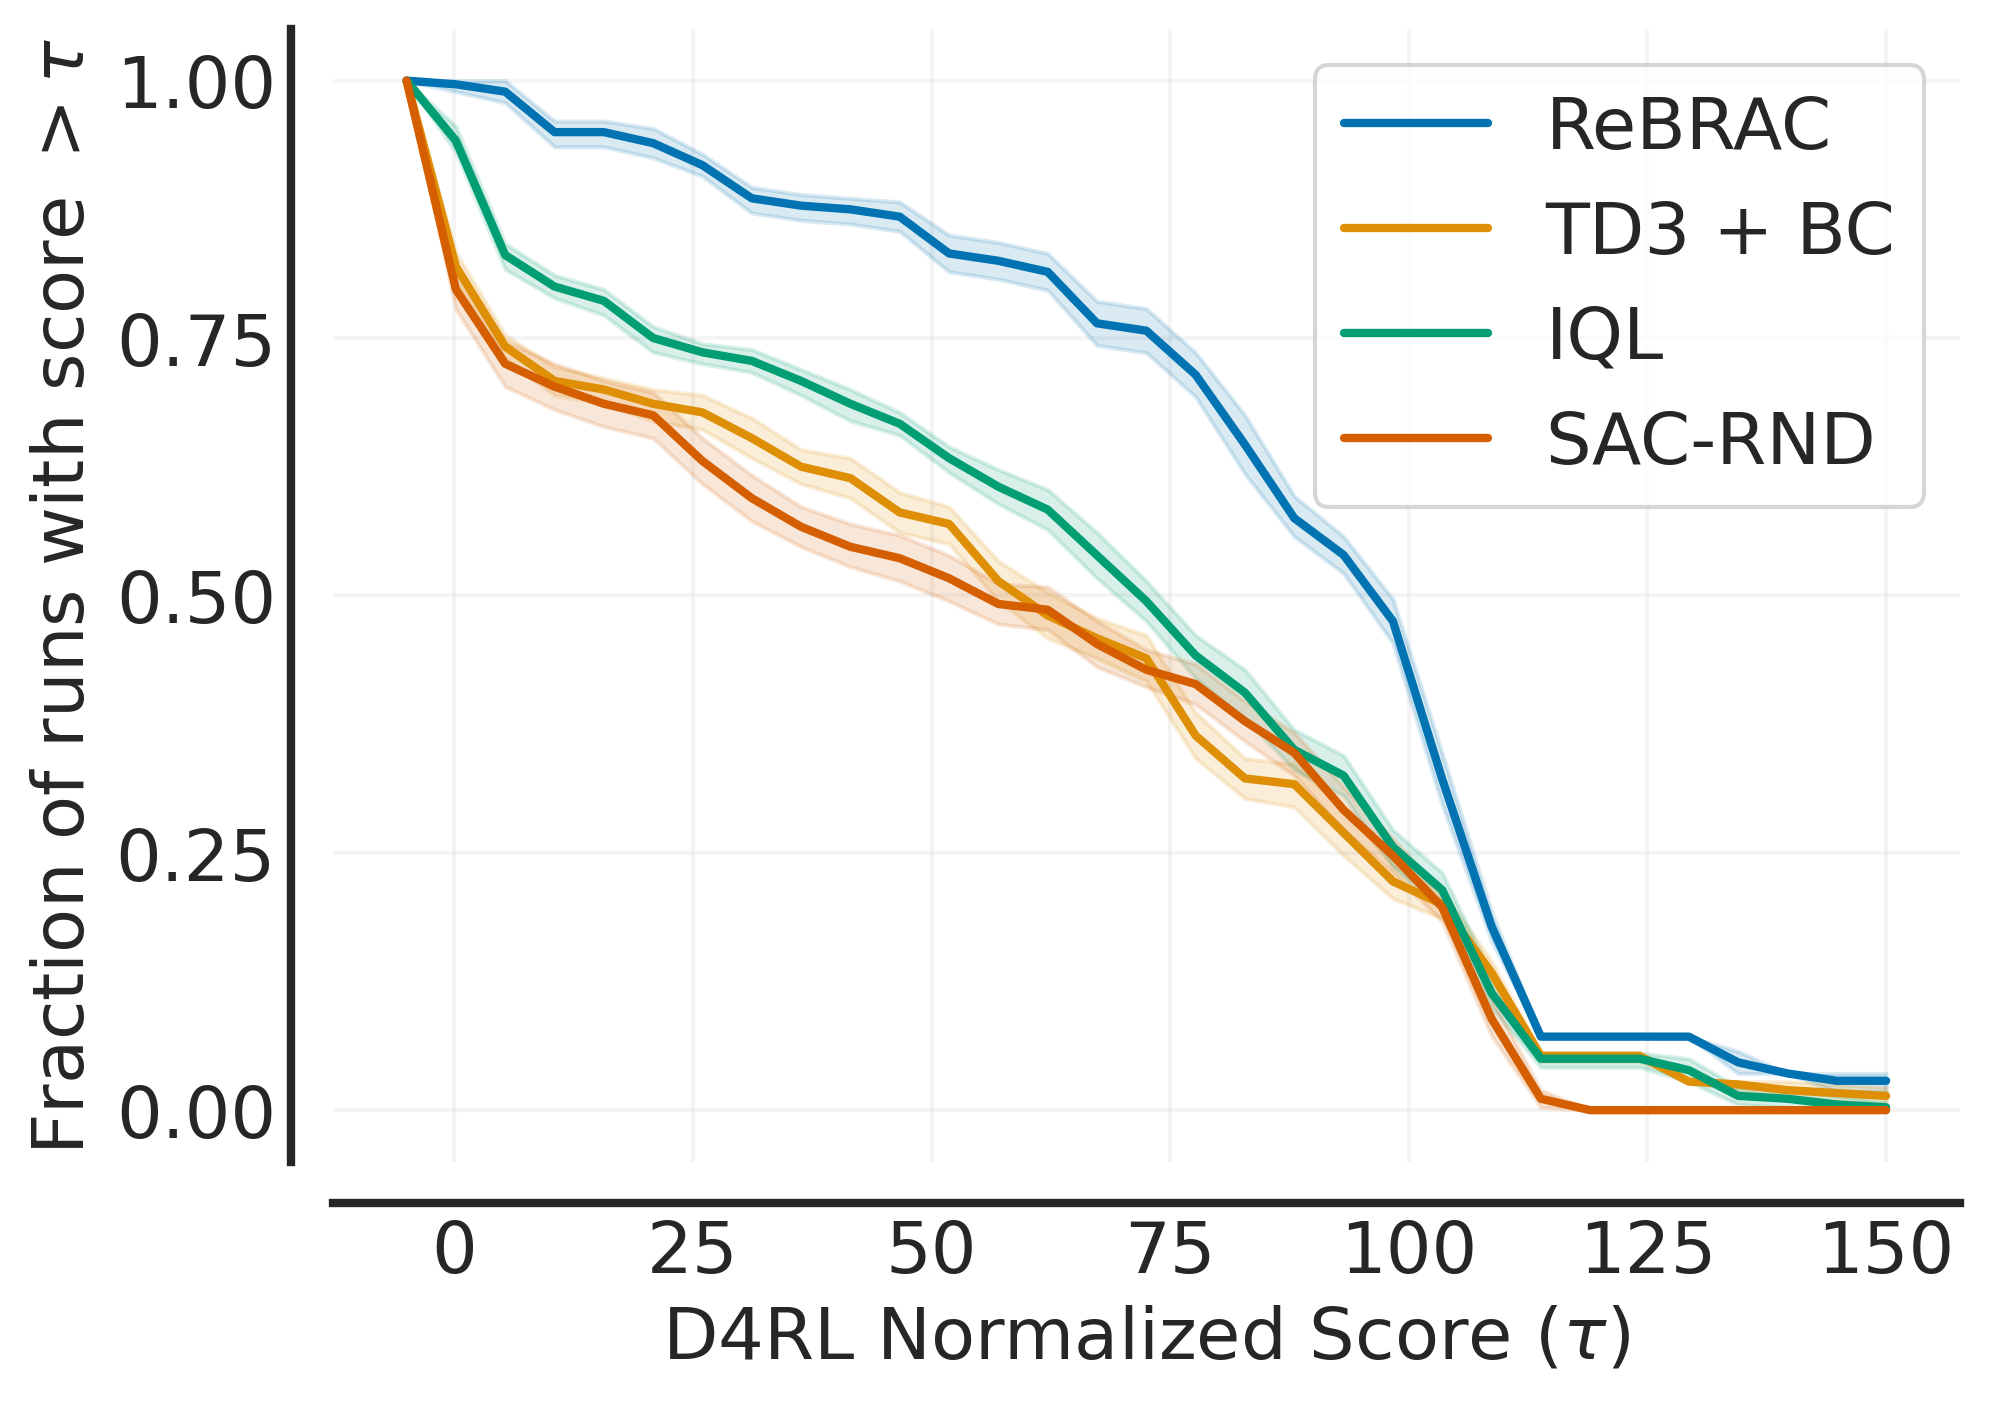

In [15]:
algorithms = ['ReBRAC', 'TD3 + BC', 'IQL', 'SAC-RND']

normalized_score_dict = {
    'ReBRAC': np.array(rebrac_flat).T,
    'TD3 + BC': np.array(td3_bc_flat).T,
    'IQL': np.array(iql_flat).T,
    'SAC-RND': np.array(sac_rnd_flat).T,
    }

# Human normalized score thresholds
thresholds = np.linspace(-5.0, 150.0, 31)
score_distributions, score_distributions_cis = rly.create_performance_profile(
    normalized_score_dict, thresholds)
# Plot score distributions
fig, ax = plt.subplots(ncols=1, figsize=(7, 5))
# plt.legend()
plot_utils.plot_performance_profiles(
  score_distributions, thresholds,
  performance_profile_cis=score_distributions_cis,
  colors=dict(zip(algorithms, sns.color_palette('colorblind'))),
  xlabel=r'D4RL Normalized Score $(\tau)$',
  ax=ax,
  legend=True
  )
plt.savefig("out/perf_profiles.pdf", dpi=300, bbox_inches='tight')

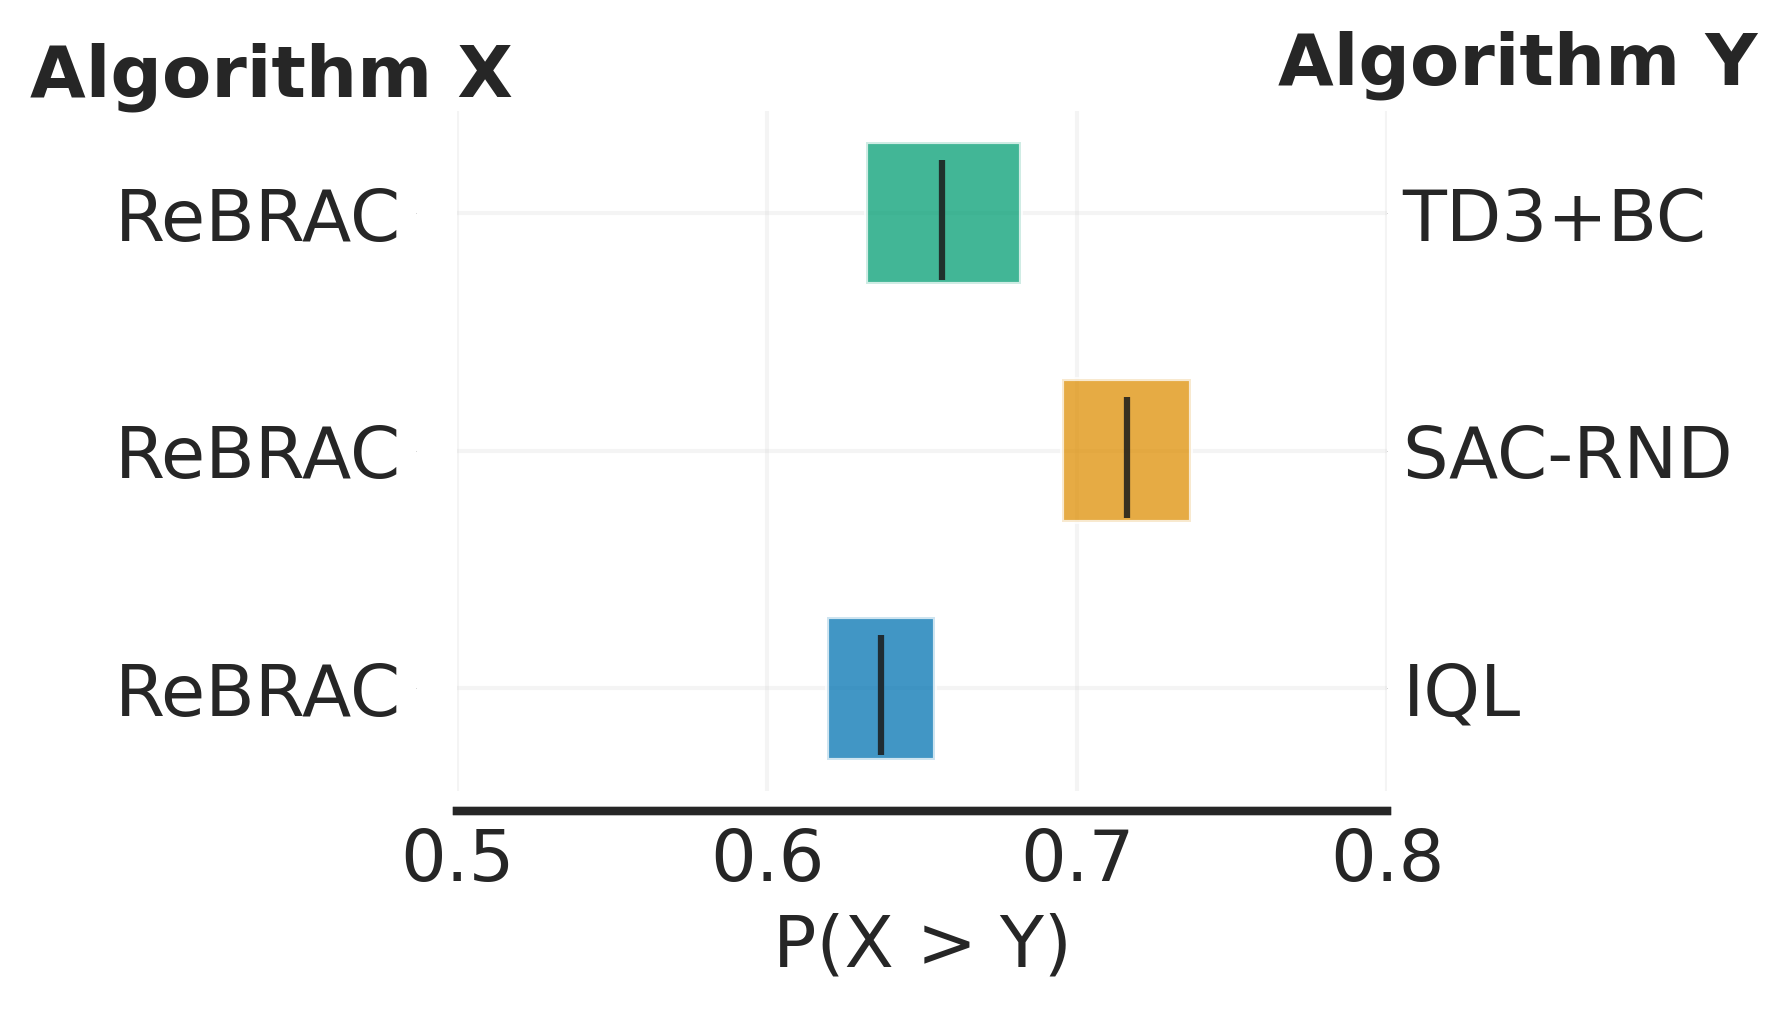

In [16]:
algorithm_pairs = {
    'ReBRAC,IQL': (np.array(rebrac_flat).T, np.array(iql_flat).T),
    'ReBRAC,SAC-RND': (np.array(rebrac_flat).T, np.array(sac_rnd_flat).T),
    'ReBRAC,TD3+BC': (np.array(rebrac_flat).T, np.array(td3_bc_flat).T),
    }
average_probabilities, average_prob_cis = rly.get_interval_estimates(
  algorithm_pairs, metrics.probability_of_improvement, reps=2000)
ax = plot_utils.plot_probability_of_improvement(average_probabilities, average_prob_cis)
ax.set_xlim(0.5, 0.8)
plt.savefig("out/improvement_probability.pdf", dpi=300, bbox_inches='tight')